# Multi-objective Robust Optimization (MORO)


This exercise demostrates the application of MORO on the lake model. In contrast to the exercises in previous weeks, we will be using a slightly more sophisticated version of the problem. For details see the MORDM assignment for this week.

## Setup MORO

Many objective robust optimization aims at finding decisions that are robust with respect to the various deeply uncertain factors. For this, MORO evalues each candidate decision over a set of scenarios. For each outcome of interest, the robusntess over this set is calculated. A MOEA is used to maximize the robustness. 

For this assignment, we will be using a domain criterion as our robustness metric. The table below lists the rules that you should use for each outcome of interest.

|Outcome of interest| threhsold  |
|-------------------|------------|
| Maximum pollution | $\leq$ 0.75|
| Inertia           | $\geq$ 0.6 |
| Reliability       | $\geq$ 0.99|   
| Utility           | $\geq$ 0.75|

**1) Implement a function for each outcome that takes a numpy array with results for the outcome of interest, and returns the robustness score**

In [110]:
from ema_workbench import Model, RealParameter, TimeSeriesOutcome, ScalarOutcome
import functools
import numpy as np

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]


    
SMALLER = 'SMALLER'
LARGER = 'LARGER'

maxp = functools.partial(robustness, SMALLER, 0.75)
inertia = functools.partial(robustness, LARGER, 0.6)
reliability = functools.partial(robustness, LARGER, 0.99)
utility = functools.partial(robustness, LARGER, 0.75)



robustnessFunctions = [ScalarOutcome('fraction max_P',
                                     kind=ScalarOutcome.MINIMIZE,
                                     variable_name='max_P',
                                     function=maxp),
                       ScalarOutcome('fraction reliability',
                                     kind=ScalarOutcome.MAXIMIZE,
                                     variable_name='reliability',
                                     function=reliability),
                       ScalarOutcome('fraction inertia',
                                     kind=ScalarOutcome.MAXIMIZE,
                                     variable_name='inertia',
                                     function=inertia),
                       ScalarOutcome('fraction utility',
                                     kind=ScalarOutcome.MAXIMIZE,
                                     variable_name='utility',
                                     function=utility)]


**2) Generate 4 random release policies, and evaluate them over 500 scenarios. Sample the scenarios using Monte Carlo sampling. Next evaulate your robustness function for 1, 2, 3, ... 500 scenarios for each outcome and visualize this. What can you tell about the convergernce of the robusntess metric as a function of the number of scenarios?**

In [111]:
# defining model
from lakemodel_function import lake_problem

from ema_workbench import (Model, RealParameter, ScalarOutcome)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

In [3]:
# running 5 scenarios 
from ema_workbench import Policy, perform_experiments
from ema_workbench import ema_logging, MultiprocessingEvaluator
import pandas as pd

ema_logging.log_to_stderr(ema_logging.INFO)
n_scenarios = 500
n_policies = 4
with MultiprocessingEvaluator(lake_model) as evaluator:
    results = perform_experiments(lake_model, n_scenarios, n_policies)

experiments, outcomes = results
policies = experiments['policy']

data = pd.DataFrame.from_dict(outcomes)
#data['policy'] = policies


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


## Searching for candidate solutions
Set up the robust optimization problem using the robustness functions you have specified. Assume that you will need 50 scenarios for estimating the robustness. Use $\epsilon$-progress and hypervolume to track convergence. Solve the optimization problem. As $\epsilon$ values, you can assume 0.05 for each of the four robustness metrics.

*note: this optimization problem is computationally very expensive. Develop and test your code using a sequential evaluator, a low number of function evaluations (e.g., 200), and a low number of scenarios (e.g., 5). Once everything seems to be working replace the sequential evaluator with an multiprocessing or ipyparallel evaluator, and increase the number of nfe and scenarios*.


In [9]:
from ema_workbench import SequentialEvaluator
from ema_workbench.em_framework import sample_uncertainties

n_scenarios = 5
scenarios = sample_uncertainties(lake_model, n_scenarios)
### leave untouched, so that you use the same set of scenarios for analysis henceforth. 


In [15]:
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)

convergence_metrics = [HyperVolume(minimum=[0,0,0,0], maximum=[1,1.01,1.01,1.01]),
                       EpsilonProgress()]
                    
nfe = 200

with SequentialEvaluator(lake_model) as evaluator:
    robust_results, convergence = evaluator.robust_optimize(robustnessFunctions,
                                                            scenarios,
                                                            nfe=nfe,                                                                                                 epsilons=[0.05,]*len(robustnessFunctions),   
                                                            convergence=convergence_metrics)


[MainProcess/INFO] generation 0: 0/200 nfe
[MainProcess/INFO] optimization completed, found 1 solutions


In [16]:
robust_results

,l0,l1,l2,l3,l4,l5,l6,l7,l8,l9,...,l94,l95,l96,l97,l98,l99,fraction max_P,fraction reliability,fraction inertia,fraction utility
0,0.06321,0.066567,0.023145,0.098848,0.063767,0.038036,0.001763,0.072835,0.083881,0.087393,...,0.012743,0.038742,0.036052,0.094349,0.019591,0.028953,0.4,0.4,1.0,0.4


**Plot your $\epsilon$-progress to evaluate convergergence, and visualize the trade-offs using parallel coordinate plots**

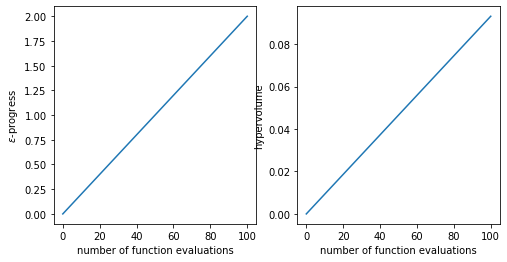

In [19]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')

plt.show()

Both EpsilonProgress and HyperVolume do not converge due to the very low value of nfe used (for the sake of easy computation)

In the next step, we replace with MultiprocessingEvaluator and try with larger value of nfe:

In [22]:
from ema_workbench import MultiprocessingEvaluator
nfe = 1000

# increasing number of scenarios: 
n_scenarios = 50
scenarios2 = sample_uncertainties(lake_model, n_scenarios)
### leave untouched, so that you use the same set of scenarios for analysis henceforth. 


with MultiprocessingEvaluator(lake_model) as evaluator:
    robust_results2, convergence2 = evaluator.robust_optimize(robustnessFunctions,
                                                            scenarios2,
                                                            nfe=nfe,                                                                                                 epsilons=[0.05,]*len(robustnessFunctions),   
                                                            convergence=convergence_metrics)


[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 500/1000 nfe
[MainProcess/INFO] optimization completed, found 10 solutions


In [23]:
robust_results2

,l0,l1,l2,l3,l4,l5,l6,l7,l8,l9,...,l94,l95,l96,l97,l98,l99,fraction max_P,fraction reliability,fraction inertia,fraction utility
0,0.092749,0.095644,0.081360,0.051201,0.034660,0.054558,0.066752,0.090828,0.030936,0.090709,...,0.008024,0.042426,0.030692,0.001731,0.060345,0.074979,0.32,0.32,1.0,0.22
1,0.096184,0.094596,0.048718,0.039935,0.088106,0.068629,0.067231,0.085704,0.031050,0.068995,...,0.046043,0.044637,0.012964,0.086923,0.027670,0.071406,0.28,0.28,1.0,0.32
2,0.067794,0.094726,0.017616,0.033881,0.027437,0.091489,0.026477,0.007682,0.051166,0.029535,...,0.032851,0.080142,0.052485,0.094606,0.080373,0.088530,0.42,0.42,1.0,0.12
3,0.051229,0.027556,0.078001,0.037520,0.019202,0.026229,0.027145,0.011666,0.000719,0.016646,...,0.028025,0.006069,0.032906,0.005871,0.060580,0.051048,0.56,0.56,0.0,0.00
4,0.088022,0.065444,0.028032,0.032227,0.086694,0.090728,0.085967,0.025124,0.046233,0.000743,...,0.088164,0.002273,0.021934,0.013821,0.042818,0.066574,0.36,0.36,1.0,0.20
5,0.051499,0.027556,0.018515,0.037538,0.036385,0.026229,0.062410,0.011620,0.000719,0.016646,...,0.016587,0.006069,0.032925,0.005871,0.056398,0.051048,0.54,0.52,0.0,0.00
6,0.095906,0.098044,0.087969,0.098758,0.069614,0.090732,0.080663,0.085655,0.048717,0.096620,...,0.026802,0.080612,0.024215,0.023625,0.091834,0.085060,0.16,0.16,1.0,0.48
7,0.083641,0.096142,0.088007,0.099385,0.096834,0.093952,0.087112,0.092080,0.070981,0.099886,...,0.095310,0.067835,0.094669,0.095021,0.081014,0.048534,0.16,0.16,0.0,0.52
8,0.095906,0.098044,0.087969,0.098758,0.083609,0.090027,0.047245,0.085513,0.030930,0.096624,...,0.026349,0.080804,0.086320,0.023237,0.091834,0.081585,0.22,0.22,1.0,0.44
9,0.067379,0.094686,0.017640,0.033881,0.027437,0.075032,0.025875,0.007682,0.000799,0.099852,...,0.092262,0.015319,0.055307,0.013721,0.080373,0.088761,0.46,0.46,1.0,0.08


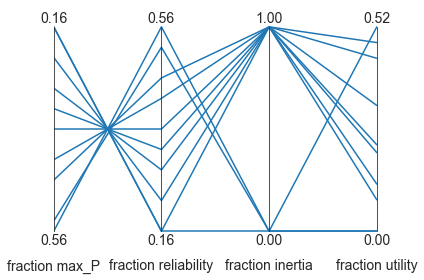

In [37]:
from ema_workbench.analysis import parcoords
import seaborn as sns

outcomes2= robust_results2.loc[:,['fraction max_P','fraction reliability','fraction inertia', 'fraction utility']]
paraxes = parcoords.ParallelAxes(parcoords.get_limits(outcomes2), rot=0)
paraxes.plot(outcomes2, color=sns.color_palette()[0])
paraxes.invert_axis('fraction max_P')
plt.show()

## Re-evaluate candidate solutions under uncertainty

We have used only 50 scenarios for the optimization. Take the results and re-evaluate them over a larger set (assume 1000 scenarios). How different are your results? What does this imply for the assumption of 50 scenarios during robust optimization.

*hint: use the to_dict method on a dataframe, next generate Policy objects in a list expression by iterating over the dicts returned by the to_dict method*

In [112]:
from ema_workbench import Policy 
levs= list(robust_results2.columns[0:100]) 
rob_modified= robust_results2.loc[:,levs]
rob_dict= rob_modified.to_dict()

policies = []
for i in range(len(rob_modified)):
    policies.append(Policy(str(i),**rob_modified.loc[i].to_dict()))



In [109]:
from ema_workbench import Policy, perform_experiments
from ema_workbench import ema_logging, MultiprocessingEvaluator
import pandas as pd

ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.perform_experiments(1000, policies)

Process ForkPoolWorker-49:
Process ForkPoolWorker-50:
Process ForkPoolWorker-52:
Process ForkPoolWorker-51:


KeyboardInterrupt: 

## Comparison
If you have time, import your solutions found for MORDM and re-evaluate them over the same set of scnearios as used for re-evaluating the MORO results. Compare the robustness of MORDM and MORO, what do you observe?